In [459]:

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from pathlib import Path 
import sys 
import os 
import logging
import seaborn as sns

from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, GroupShuffleSplit

from collections import Counter

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GroupKFold,  cross_validate
from sklearn.base import BaseEstimator, TransformerMixin

from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor

from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, classification_report, confusion_matrix

sys.path.append('/Users/alina/Desktop/MIT/code/ADHD/MTA/helper')
from helper import rr, prep, var_dict, audit, plot, save


%load_ext autoreload
%autoreload 2

#shap.initjs()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [460]:
if Path('/Volumes/Samsung_T5/MIT/mta').exists():
    data_root =     '/Volumes/Samsung_T5/MIT/mta'
    data_derived  = '/Volumes/Samsung_T5/MIT/mta/output/derived_data'
else: 
    data_root = '/Users/alina/Desktop/MIT/code/data'
    data_derived  = '/Users/alina/Desktop/MIT/code/data/output/derived_data'

info_path = Path(data_root, "files")
#os.listdir(data_derived)


## Load data 

In [461]:
################## PREDICTORS ####################
pred = pd.read_csv(Path(data_derived, 'mta_data_clean.csv')).drop(columns = 'Unnamed: 0')
out = pd.read_csv(Path(data_derived, 'out_clean_all_raters.csv')).drop(columns = 'Unnamed: 0')

rater_out = 'm'
rater_pred = 'm' # if set to None use all raters 

thr_drop_missing = 50 # if changed to lower number, some cols will be dropped, 50 iwas threshold in preprcessing (wont change anything)


In [462]:

if rater_pred is not None:
    col_pred = [ col for col in pred.columns if col.endswith(rater_pred)]
    col_pred.append("src_subject_id")
    col_pred.append('trtname')
    pred = pred[col_pred]
    
    
 ################ OUTCOMES ##################   

col_out_rater = [col for col in out if col.endswith(rater_out)]

out_rater = out[np.concatenate((['src_subject_id'], col_out_rater))]

for col in col_out_rater:
    print(col, out_rater[col].dropna().shape)

out_rater = out_rater.rename(columns={col: f"{col}_out" for col in out_rater.columns if col != 'src_subject_id'})


################ MERGE ##############
data = pd.merge(out_rater, pred, how = 'left', on = 'src_subject_id')
data = audit.remove_cols(data, thr_drop_missing=thr_drop_missing) # adjust if desired, as loaded thr was 50 

y_cols = [col for col in data.columns if col.endswith('out')]
print('possible outcomes : ', y_cols)
y_col = y_cols[2] # extrcat single outcome to predict 
print('To predict : ', y_col)

X_cols = [col for col in data.columns if col not in y_cols]
data = data.dropna(subset=[y_col])

y = np.array(data[y_col])
df_X = data[X_cols].drop(columns='src_subject_id')

snap_snainatt_m (502,)
snap_snahypat_m (503,)
snap_snaoddt_m (503,)
ssrs_sspintt_m (497,)
ssrs_ssptosst_m (496,)
pcrc_pcrcpax_m (520,)
pcrc_pcrcprx_m (521,)
Index([], dtype='object')
Removing empty columns ..  N =  0
Index([], dtype='object')
(559, 286)
Removing constant columns .. N =  0
Index([], dtype='object')
(559, 286)
Removing known and raw columns..  N =  : 0
[]
(559, 286)
Removing above threshold empty columns.. N =  : 0
set()
(559, 286)
possible outcomes :  ['snap_snainatt_m_out', 'snap_snahypat_m_out', 'snap_snaoddt_m_out', 'ssrs_sspintt_m_out', 'ssrs_ssptosst_m_out', 'pcrc_pcrcpax_m_out', 'pcrc_pcrcprx_m_out']
To predict :  snap_snaoddt_m_out


## Get variable types 

In [479]:
col_names_data = list(data.columns)
col_names_data
ord_vars, num_vars, cat_vars = [], [], []

types_df =  pd.read_excel(Path(data_derived, 'all_vars_description_ML.xlsx'), sheet_name='Sheet1')

for i, var in enumerate(types_df.iterrows()):

    var_name = var[1][1]

    type_ = var[1][4]
    var_in_data = [ col for col in col_names_data if var_name in col]
    if type_ == "ord":
        ord_vars.append(var_in_data)
    elif type_ == "num":
        num_vars.append(var_in_data)
    elif type_ == "cat":
        cat_vars.append(var_in_data)
        
cat_vars.append(['trtname'])
        
ord_vars = np.concatenate(ord_vars)
cat_vars = np.concatenate(cat_vars)
num_vars = np.concatenate(num_vars)

/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_93524/19574433.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  var_name = var[1][1]
/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_93524/19574433.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  type_ = var[1][4]


In [480]:
qsts = set([var.split('_')[0] for var in pred.columns])
qsts.remove('src')
qsts.remove('trtname')
qsts

{'cbcl', 'expect', 'pcrc', 'scid', 'snap', 'ssrs'}

### Verify loading and types

In [481]:
# Define the extensions to check
extensions = ['_m', #mother 
              #'_p'# proffesionals
              '_f', # father,
              '_c',# child,
              '_t'] # teacher 

# Count columns for each extension
extension_counts = {ext: sum(col.endswith(ext) for col in pred.columns) for ext in extensions}

for ext, count in extension_counts.items():
    print(f"Columns ending with '{ext}': {count}")

Columns ending with '_m': 277
Columns ending with '_f': 0
Columns ending with '_c': 0
Columns ending with '_t': 0


In [482]:
all_var_types_test = [col for col in data.columns if not col in np.concatenate((cat_vars, num_vars, ord_vars)) ]
assert all_var_types_test == ['src_subject_id'] # if fails there are not correctly assigned data types 


## Define ML params

In [483]:
params = { 'tune_hyperparam' : False,
          'temp_size' : 0.3, # Size of 
          'test_size' : 0.3,
          'random_state' : 42, 
          'num_top_features': 10, # number of features to keep after featur selection, change to when it doesnt get better anymore 
          'stratify' : 'trtname',
          'gkf_n_splits' : 5} # in balance in train teat split 

num_vars_in = [col for col in num_vars if not col.endswith("out")] # name of numerical variables present in dataframe X (excludin var names in y)

scoring = {
    'r2': 'r2',
    'mse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}

groups = data['src_subject_id'].values

## Handle missing values 

In [484]:
df_X.columns

Index(['expect_exp1_m', 'expect_exp2_m', 'expect_exp3_m', 'expect_exp4_m',
       'expect_exp5_m', 'expect_exp6_m', 'expect_exptott_m',
       'snap_snap_adhd_1_m', 'snap_snap_adhd_2_m', 'snap_snap_adhd_3_m',
       ...
       'scid_axsima_m', 'scid_axoca1_m', 'scid_axoc1_m', 'scid_axgada_m',
       'scid_smchk1_m', 'scid_smchk2_m', 'scid_edanoa_m', 'scid_edbula_m',
       'scid_adjchk_m', 'trtname'],
      dtype='object', length=278)

## Train-Test split 30 % test, 70% train --> train used for CV 

In [485]:


X_select = df_X[np.concatenate((num_vars_in, ord_vars))]#, cat_vars))]




In [486]:
cat_vars_str , cat_vars_num , rest = [], [],[]
for col in cat_vars:
    if isinstance(data[col].dropna().unique()[0], str):
        cat_vars_str.append(col)
    elif isinstance(data[col].dropna().unique()[0], float):
        cat_vars_num.append(col)
    else:
        rest.append(col)
assert rest == []
print(cat_vars_str)
print(cat_vars_num)

['scid_ethnic_group_m', 'scid_das1ms_m', 'trtname']
['scid_axisidx_m', 'scid_pastpsy_m', 'scid_maniachk_m', 'scid_dyschk_m', 'scid_mochk1_m', 'scid_sualchk_m', 'scid_smchk1_m', 'scid_smchk2_m', 'scid_adjchk_m', 'cbcl_special_ed_m', 'cbcl_repeat_grade_m', 'cbcl_academic_m']


In [ ]:
# for col in cat_vars_str:
#     data[col] = data[col].fillna('Missing').astype(str)

In [472]:
data[cat_vars]

,scid_axisidx_m,scid_ethnic_group_m,scid_das1ms_m,scid_pastpsy_m,scid_maniachk_m,scid_dyschk_m,scid_mochk1_m,scid_sualchk_m,scid_smchk1_m,scid_smchk2_m,scid_adjchk_m,cbcl_special_ed_m,cbcl_repeat_grade_m,cbcl_academic_m,trtname
0,23.0,"White, not of Hispanic origin",married once,2.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,0.0,1.0,C
1,0.0,Missing,Missing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,M
2,NaN,"White, not of Hispanic origin",married once,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,0.0,0.0,0.0,M
3,0.0,"Black, not of Hispanic origin",widowed,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,A
4,23.0,"White, not of Hispanic origin",married once,2.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,0.0,"White, not of Hispanic origin",married once,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,P
553,0.0,Missing,Missing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,C
554,0.0,Missing,Missing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,P
556,0.0,Missing,Missing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,C


In [487]:
# Define the custom CorrelationSelector
class CorrelationSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.8):
        self.threshold = threshold
        self.features_to_keep_ = None
        self.to_drop_ = None
    
    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("CorrelationSelector expects input X to be a pandas DataFrame")
        
        corr_matrix = X.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.to_drop_ = [column for column in upper.columns if any(upper[column] > self.threshold)]
        self.features_to_keep_ = [column for column in X.columns if column not in self.to_drop_]
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("CorrelationSelector expects input X to be a pandas DataFrame")
        return X[self.features_to_keep_]
    
    def get_support(self, indices=False):
        if indices:
            return [i for i, col in enumerate(self.features_to_keep_)]
        else:
            return self.features_to_keep_
        


In [488]:
print(data[cat_vars_num].dtypes)
print(data[cat_vars_str].dtypes)

scid_axisidx_m         float64
scid_pastpsy_m         float64
scid_maniachk_m        float64
scid_dyschk_m          float64
scid_mochk1_m          float64
scid_sualchk_m         float64
scid_smchk1_m          float64
scid_smchk2_m          float64
scid_adjchk_m          float64
cbcl_special_ed_m      float64
cbcl_repeat_grade_m    float64
cbcl_academic_m        float64
dtype: object
scid_ethnic_group_m    object
scid_das1ms_m          object
trtname                object
dtype: object


In [490]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Seed for reproducibility
np.random.seed(42)

# Example parameters dictionary
params = {
    'test_size': 0.2,
    'random_state': 42
}

# Ensure X is a DataFrame
X = X_select.copy()

# Initialize GroupShuffleSplit for initial train-test split
gss_test = GroupShuffleSplit(n_splits=1, test_size=params['test_size'], random_state=params['random_state'])
train_val_idx, test_idx = next(gss_test.split(X, y, groups=groups))

# Split data into training-validation and test sets
X_test, y_test, groups_test = X.iloc[test_idx], y[test_idx], groups[test_idx]
X_train_val, y_train_val, groups_train_val = X.iloc[train_val_idx], y[train_val_idx], groups[train_val_idx]

print(f"Total samples: {X.shape[0]}")
print('TRAIN_VAL ', X_train_val.shape, y_train_val.shape)
print('TEST', X_test.shape, y_test.shape)

assert X.shape[0] == y.shape[0] == groups.shape[0], "Mismatch in number of samples between X, y, and groups."

# Count group sizes
group_counts = Counter(groups_train_val)
max_group_size = max(group_counts.values())
logger.info(f"Maximum group size: {max_group_size}")

# Define number of splits
n_outer_splits = 5
n_inner_splits = 3

# Check if group sizes exceed number of splits
if max_group_size > n_outer_splits or max_group_size > n_inner_splits:
    logger.warning("Some groups are larger than the number of splits.")
    logger.warning("Consider reducing the number of splits or aggregating groups.")
else:
    logger.info("All groups are appropriately sized for the number of splits.")

logger.info(f"Number of unique groups: {len(np.unique(groups_train_val))}")
logger.info(f"Sample groups: {np.unique(groups_train_val)[:10]}")

# Initialize GroupKFold for outer and inner CV
outer_cv = GroupKFold(n_splits=n_outer_splits)
inner_cv = GroupKFold(n_splits=n_inner_splits)





categorical_str_transformer = Pipeline([
    #('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('ordinal', OrdinalEncoder(handle_unknown='ignore', unknown_value=-1)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])
# Define the categorical transformer
categorical_num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])
# Define the ColumnTransformer with OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_str', categorical_str_transformer, cat_vars_str),
        ('cat_num', categorical_num_transformer, cat_vars_num)
    ],
    remainder='passthrough'  # Keep other features unchanged
)

# Define the pipeline with feature selection and model training
pipeline = Pipeline([
    # ('preprocessor', preprocessor),
    ('correlation_selector', CorrelationSelector(threshold=0.8)),
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))
])







# Define hyperparameter grid
param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [5, 7],
    'xgb__learning_rate': [0.1, 0.2],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=inner_cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Placeholder for results
nested_scores = []
best_params = []

# Perform Nested Cross-Validation on the training-validation set
for fold, (train_idx, val_idx) in enumerate(outer_cv.split(X_train_val, y_train_val, groups=groups_train_val), 1):
    logger.info(f"\n--- Outer Fold {fold} ---")
    
    # Split data into training and validation sets for this fold
    X_outer_train, X_outer_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_outer_train, y_outer_val = y_train_val[train_idx], y_train_val[val_idx]
    groups_outer_train = groups_train_val[train_idx]
    
    # Fit GridSearchCV (inner loop) on the outer training data
    try:
        grid_search.fit(X_outer_train, y_outer_train, groups=groups_outer_train)
    except Exception as e:
        logger.error(f"Error in GridSearchCV for fold {fold}: {e}")
        continue  # Skip to the next fold
    
    # Best model from inner loop
    best_model = grid_search.best_estimator_
    best_params.append(grid_search.best_params_)
    
    # Predict on the outer validation set
    try:
        y_pred = best_model.predict(X_outer_val)
    except Exception as e:
        logger.error(f"Error during prediction for fold {fold}: {e}")
        continue  # Skip to the next fold
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_outer_val, y_pred)
    r2 = r2_score(y_outer_val, y_pred)
    nested_scores.append({'mse': mse, 'r2': r2})
    
    logger.info(f"Best Params: {grid_search.best_params_}")
    logger.info(f"Fold {fold} MSE: {mse:.4f}, R²: {r2:.4f}")
    
    # Analyze selected features
    selector = best_model.named_steps['correlation_selector']
    selected_features = selector.features_to_keep_
    logger.info(f"Fold {fold} Selected Features: {selected_features}")

# Summarize Nested CV Results
if nested_scores:
    mean_mse = np.mean([score['mse'] for score in nested_scores])
    std_mse = np.std([score['mse'] for score in nested_scores])
    mean_r2 = np.mean([score['r2'] for score in nested_scores])
    std_r2 = np.std([score['r2'] for score in nested_scores])
    
    logger.info("\n=== Nested Cross-Validation Results ===")
    logger.info(f"Mean MSE: {mean_mse:.4f}")
    logger.info(f"Standard Deviation MSE: {std_mse:.4f}")
    logger.info(f"Mean R²: {mean_r2:.4f}")
    logger.info(f"Standard Deviation R²: {std_r2:.4f}")
    
    # Analyze most common hyperparameters
    common_params = Counter(tuple(sorted(d.items())) for d in best_params)
    most_common = common_params.most_common(1)[0][0]
    best_hyperparameters = dict(most_common)
    
    logger.info(f"\nMost Common Best Hyperparameters: {best_hyperparameters}")
else:
    logger.info("No successful folds to report.")

INFO:__main__:Maximum group size: 1
INFO:__main__:All groups are appropriately sized for the number of splits.
INFO:__main__:Number of unique groups: 402
INFO:__main__:Sample groups: ['P1003' 'P1005' 'P1006' 'P1007' 'P1008' 'P1009' 'P1010' 'P1013' 'P1016'
 'P1017']
INFO:__main__:
--- Outer Fold 1 ---


Total samples: 503
TRAIN_VAL  (402, 342) (402,)
TEST (101, 342) (101,)
Fitting 3 folds for each of 32 candidates, totalling 96 fits


INFO:__main__:Best Params: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
INFO:__main__:Fold 1 MSE: 21.9833, R²: 0.3733
INFO:__main__:Fold 1 Selected Features: ['snap_snainatt_m', 'snap_snahypat_m', 'snap_snaimput_m', 'snap_snaoddt_m', 'snap_snatotlt_m', 'ssrs_sspcoopt_m', 'ssrs_sspasrtt_m', 'ssrs_sspscont_m', 'ssrs_ssptosst_m', 'ssrs_sspextt_m', 'ssrs_sspintt_m', 'ssrs_ssphypt_m', 'pcrc_pcrcposx_m', 'pcrc_pcrcprox_m', 'pcrc_pcrcaffx_m', 'pcrc_pcrcqurx_m', 'pcrc_pcrcsocx_m', 'pcrc_pcrcsimx_m', 'pcrc_pcrcprax_m', 'pcrc_pcrcdomx_m', 'pcrc_pcrcintx_m', 'pcrc_pcrcppnx_m', 'pcrc_pcrcadpx_m', 'pcrc_pcrcadcx_m', 'pcrc_pcrcprix_m', 'pcrc_pcrcnurx_m', 'pcrc_pcrcvpnx_m', 'pcrc_pcrcdecx_m', 'pcrc_pcrccomx_m', 'pcrc_pcrcgltx_m', 'pcrc_pcrcratx_m', 'pcrc_pcrcpax_m', 'pcrc_pcrcprx_m', 'pcrc_pcrcdwx_m', 'snap_sna19_m', 'snap_sna20_m', 'snap_sna21_m', 'snap_sna22_m', 'snap_sna23_m', 'snap_sna24_m', 'snap_sna25_m', 'snap_s

Fitting 3 folds for each of 32 candidates, totalling 96 fits


INFO:__main__:Best Params: {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
INFO:__main__:Fold 2 MSE: 24.6193, R²: 0.2007
INFO:__main__:Fold 2 Selected Features: ['snap_snainatt_m', 'snap_snahypat_m', 'snap_snaimput_m', 'snap_snaoddt_m', 'snap_snatotlt_m', 'ssrs_sspcoopt_m', 'ssrs_sspasrtt_m', 'ssrs_sspscont_m', 'ssrs_ssptosst_m', 'ssrs_sspextt_m', 'ssrs_sspintt_m', 'ssrs_ssphypt_m', 'pcrc_pcrcposx_m', 'pcrc_pcrcprox_m', 'pcrc_pcrcaffx_m', 'pcrc_pcrcqurx_m', 'pcrc_pcrcsocx_m', 'pcrc_pcrcsimx_m', 'pcrc_pcrcprax_m', 'pcrc_pcrcdomx_m', 'pcrc_pcrcintx_m', 'pcrc_pcrcppnx_m', 'pcrc_pcrcadpx_m', 'pcrc_pcrcadcx_m', 'pcrc_pcrcprix_m', 'pcrc_pcrcnurx_m', 'pcrc_pcrcvpnx_m', 'pcrc_pcrcdecx_m', 'pcrc_pcrccomx_m', 'pcrc_pcrcgltx_m', 'pcrc_pcrcratx_m', 'pcrc_pcrcpax_m', 'pcrc_pcrcprx_m', 'pcrc_pcrcdwx_m', 'snap_sna19_m', 'snap_sna20_m', 'snap_sna21_m', 'snap_sna22_m', 'snap_sna23_m', 'snap_sna24_m', 'snap_sna25_m', 'snap_s

Fitting 3 folds for each of 32 candidates, totalling 96 fits


INFO:__main__:Best Params: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 100, 'xgb__subsample': 1.0}
INFO:__main__:Fold 3 MSE: 28.3325, R²: 0.2840
INFO:__main__:Fold 3 Selected Features: ['snap_snainatt_m', 'snap_snahypat_m', 'snap_snaimput_m', 'snap_snaoddt_m', 'snap_snatotlt_m', 'ssrs_sspcoopt_m', 'ssrs_sspasrtt_m', 'ssrs_sspscont_m', 'ssrs_ssptosst_m', 'ssrs_sspextt_m', 'ssrs_sspintt_m', 'ssrs_ssphypt_m', 'pcrc_pcrcposx_m', 'pcrc_pcrcprox_m', 'pcrc_pcrcaffx_m', 'pcrc_pcrcqurx_m', 'pcrc_pcrcsocx_m', 'pcrc_pcrcsimx_m', 'pcrc_pcrcprax_m', 'pcrc_pcrcdomx_m', 'pcrc_pcrcintx_m', 'pcrc_pcrcppnx_m', 'pcrc_pcrcadpx_m', 'pcrc_pcrcadcx_m', 'pcrc_pcrcprix_m', 'pcrc_pcrcnurx_m', 'pcrc_pcrcvpnx_m', 'pcrc_pcrcdecx_m', 'pcrc_pcrccomx_m', 'pcrc_pcrcgltx_m', 'pcrc_pcrcratx_m', 'pcrc_pcrcpax_m', 'pcrc_pcrcprx_m', 'pcrc_pcrcdwx_m', 'snap_sna19_m', 'snap_sna20_m', 'snap_sna21_m', 'snap_sna22_m', 'snap_sna23_m', 'snap_sna24_m', 'snap_sna25_m', 'snap_s

Fitting 3 folds for each of 32 candidates, totalling 96 fits


INFO:__main__:Best Params: {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
INFO:__main__:Fold 4 MSE: 28.9900, R²: 0.1155
INFO:__main__:Fold 4 Selected Features: ['snap_snainatt_m', 'snap_snahypat_m', 'snap_snaimput_m', 'snap_snaoddt_m', 'snap_snatotlt_m', 'ssrs_sspcoopt_m', 'ssrs_sspasrtt_m', 'ssrs_sspscont_m', 'ssrs_ssptosst_m', 'ssrs_sspextt_m', 'ssrs_sspintt_m', 'ssrs_ssphypt_m', 'pcrc_pcrcposx_m', 'pcrc_pcrcprox_m', 'pcrc_pcrcaffx_m', 'pcrc_pcrcqurx_m', 'pcrc_pcrcsocx_m', 'pcrc_pcrcsimx_m', 'pcrc_pcrcprax_m', 'pcrc_pcrcdomx_m', 'pcrc_pcrcintx_m', 'pcrc_pcrcppnx_m', 'pcrc_pcrcadpx_m', 'pcrc_pcrcadcx_m', 'pcrc_pcrcprix_m', 'pcrc_pcrcnurx_m', 'pcrc_pcrcvpnx_m', 'pcrc_pcrcdecx_m', 'pcrc_pcrccomx_m', 'pcrc_pcrcgltx_m', 'pcrc_pcrcratx_m', 'pcrc_pcrcpax_m', 'pcrc_pcrcprx_m', 'pcrc_pcrcdwx_m', 'snap_sna19_m', 'snap_sna20_m', 'snap_sna21_m', 'snap_sna22_m', 'snap_sna23_m', 'snap_sna24_m', 'snap_sna25_m', 'snap_s

Fitting 3 folds for each of 32 candidates, totalling 96 fits


INFO:__main__:Best Params: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
INFO:__main__:Fold 5 MSE: 23.0896, R²: -0.1739
INFO:__main__:Fold 5 Selected Features: ['snap_snainatt_m', 'snap_snahypat_m', 'snap_snaimput_m', 'snap_snaoddt_m', 'snap_snatotlt_m', 'ssrs_sspcoopt_m', 'ssrs_sspasrtt_m', 'ssrs_sspscont_m', 'ssrs_ssptosst_m', 'ssrs_sspextt_m', 'ssrs_sspintt_m', 'ssrs_ssphypt_m', 'pcrc_pcrcposx_m', 'pcrc_pcrcprox_m', 'pcrc_pcrcaffx_m', 'pcrc_pcrcqurx_m', 'pcrc_pcrcsocx_m', 'pcrc_pcrcsimx_m', 'pcrc_pcrcprax_m', 'pcrc_pcrcdomx_m', 'pcrc_pcrcintx_m', 'pcrc_pcrcppnx_m', 'pcrc_pcrcadpx_m', 'pcrc_pcrcadcx_m', 'pcrc_pcrcprix_m', 'pcrc_pcrcnurx_m', 'pcrc_pcrcvpnx_m', 'pcrc_pcrcdecx_m', 'pcrc_pcrccomx_m', 'pcrc_pcrcgltx_m', 'pcrc_pcrcratx_m', 'pcrc_pcrcpax_m', 'pcrc_pcrcprx_m', 'pcrc_pcrcdwx_m', 'snap_sna19_m', 'snap_sna20_m', 'snap_sna21_m', 'snap_sna22_m', 'snap_sna23_m', 'snap_sna25_m', 'snap_sna26_m', 'snap_

## Define pipeline

In [ ]:


y_trues = np.array(y)
y_preds = np.array(y_pred)

# Calculate residuals
residuals = y_trues - y_preds

# Create the residual plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_preds, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

ValueError: operands could not be broadcast together with shapes (503,) (80,) 

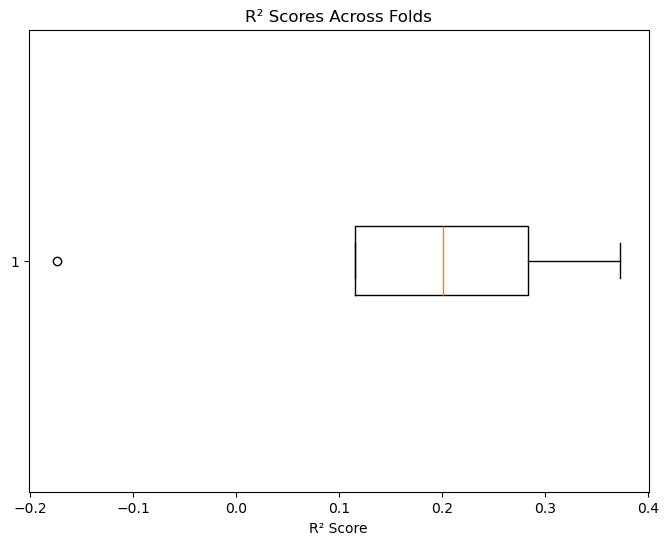

In [380]:
r2_scores = [score['r2'] for score in nested_scores]

plt.figure(figsize=(8,6))
plt.boxplot(r2_scores, vert=False)
plt.xlabel('R² Score')
plt.title('R² Scores Across Folds')
plt.show()

In [333]:
importances = best_model.named_steps['xgb'].feature_importances_
importances

array([1.16292934e-03, 1.08863960e-03, 1.62733987e-03, 1.40926894e-03,
       1.21016251e-02, 3.52993072e-03, 5.07725868e-04, 1.40364713e-03,
       4.00208216e-03, 2.70794565e-03, 1.22636836e-03, 1.66549732e-03,
       2.52677966e-03, 1.30032084e-03, 2.11609043e-02, 5.30610513e-03,
       3.93441552e-03, 2.38452461e-02, 1.48641621e-03, 3.32645234e-03,
       2.99866241e-03, 1.19684013e-02, 1.72459753e-03, 2.76298868e-03,
       2.54944456e-03, 3.39908642e-03, 2.15630513e-03, 2.15546577e-03,
       4.93259984e-04, 2.73777475e-03, 2.42111948e-03, 1.54558744e-03,
       3.64347617e-03, 2.24726577e-03, 4.10521636e-03, 1.23489567e-03,
       2.68098316e-03, 3.01802019e-03, 1.27253840e-02, 1.60116295e-03,
       3.76079883e-03, 1.82765350e-03, 3.83896264e-03, 8.26299470e-03,
       8.10119091e-04, 1.56018687e-02, 1.90853106e-03, 3.83437681e-03,
       7.31515791e-03, 2.65809195e-03, 3.89501778e-03, 1.16881996e-03,
       2.15627882e-03, 2.85016466e-03, 4.92201559e-03, 7.98082212e-04,
      

In [383]:
importances = best_model.named_steps['xgb'].feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plotting feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances[:20], y=feature_importances.index[:20])
plt.title('Top 20 Feature Importances')
plt.show()

ValueError: Length of values (162) does not match length of index (342)

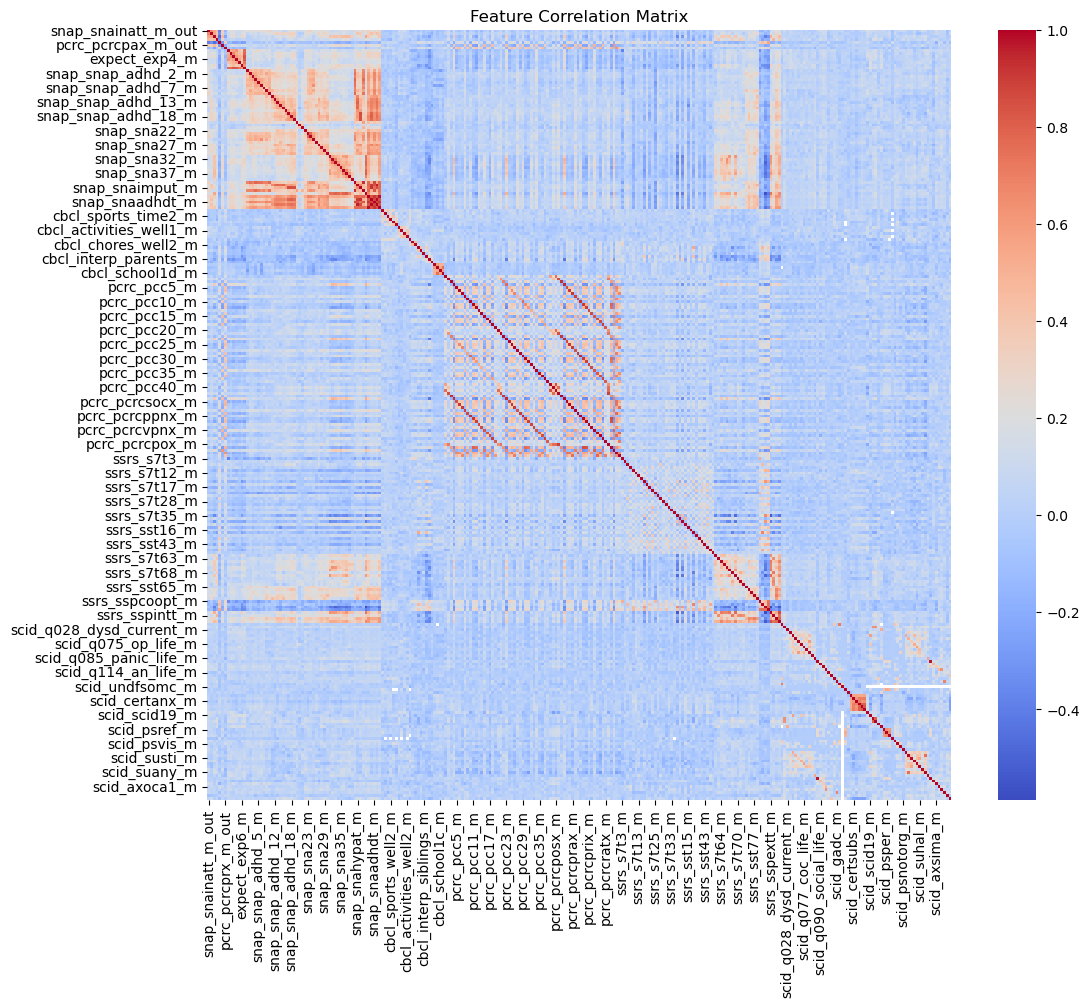

In [320]:
correlation_matrix = data.drop(columns=np.concatenate((cat_vars, ['src_subject_id']))).corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [ ]:
# from sklearn.dummy import DummyRegressor

# dummy = DummyRegressor(strategy='mean')
# dummy.fit(X_train, y_train)
# y_pred_dummy = dummy.predict(X_val)

# r2_dummy = r2_score(y_val, y_pred_dummy)
# mse_dummy = mean_squared_error(y_val, y_pred_dummy)
# mae_dummy = mean_absolute_error(y_val, y_pred_dummy)

# print(f"Dummy R²: {r2_dummy:.4f}, MSE: {mse_dummy:.4f}, MAE: {mae_dummy:.4f}")

Dummy R²: -0.0025, MSE: 28.1166, MAE: 4.4586


In [ ]:
# encoder = OneHotEncoder(drop="first", handle_unknown='ignore')
# encoder.fit(X_train[cat_vars])

# # Identify unique categories in training and validation/test sets
# train_categories = encoder.categories_[0]
# validation_categories = X_val[cat_vars].iloc[:, 0].unique()

# # Find unknown categories
# unknown_categories = set(validation_categories) - set(train_categories)
# print(f"Unknown Categories in Validation/Test Set: {unknown_categories}")

Unknown Categories in Validation/Test Set: {nan}


In [389]:
from sklearn.ensemble import RandomForestRegressor

INFO:__main__:Maximum group size: 1
INFO:__main__:All groups are appropriately sized for the number of splits.
INFO:__main__:Number of unique groups: 402
INFO:__main__:Sample groups: ['P1003' 'P1005' 'P1006' 'P1007' 'P1008' 'P1009' 'P1010' 'P1013' 'P1016'
 'P1017']
INFO:__main__:
--- Outer Fold 1 ---


Total samples: 503
TRAIN_VAL  (402, 342) (402,)
TEST (101, 342) (101,)
Fitting 3 folds for each of 216 candidates, totalling 648 fits


/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
216 fits failed out of a total of 648.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/sklearn/pipeline.py", li

Fitting 3 folds for each of 216 candidates, totalling 648 fits


/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
216 fits failed out of a total of 648.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
79 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/sklearn/pipeline.py", li

Fitting 3 folds for each of 216 candidates, totalling 648 fits


/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
216 fits failed out of a total of 648.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
144 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/sklearn/pipeline.py", l

Fitting 3 folds for each of 216 candidates, totalling 648 fits


/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
216 fits failed out of a total of 648.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/sklearn/pipeline.py", l

Fitting 3 folds for each of 216 candidates, totalling 648 fits


/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
216 fits failed out of a total of 648.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/sklearn/pipeline.py", l

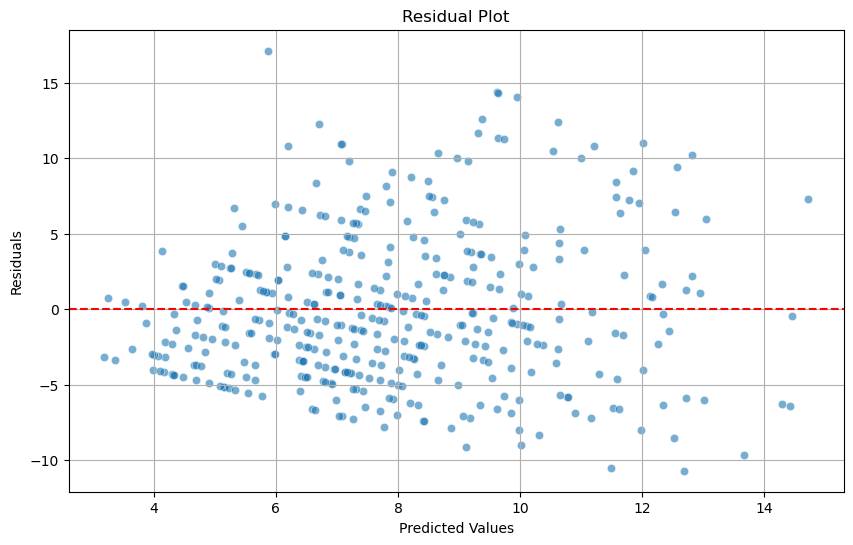

In [390]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Seed for reproducibility
np.random.seed(42)

# Example parameters dictionary
params = {
    'test_size': 0.2,
    'random_state': 42
}

# Assuming X_select is a DataFrame, y and groups are defined
# Replace the following lines with your actual data loading/preprocessing
# X_select = pd.read_csv('your_features.csv')
# y = X_select['target'].values  # or y = X_select['target']
# groups = X_select['src_subject_id'].values  # or groups = X_select['src_subject_id']

# Ensure X is a DataFrame
X = X_select.copy()

# Initialize GroupShuffleSplit for initial train-test split
gss_test = GroupShuffleSplit(n_splits=1, test_size=params['test_size'], random_state=params['random_state'])
train_val_idx, test_idx = next(gss_test.split(X, y, groups=groups))

# Split data into training-validation and test sets
X_test, y_test, groups_test = X.iloc[test_idx], y[test_idx], groups[test_idx]
X_train_val, y_train_val, groups_train_val = X.iloc[train_val_idx], y[train_val_idx], groups[train_val_idx]

print(f"Total samples: {X.shape[0]}")
print('TRAIN_VAL ', X_train_val.shape, y_train_val.shape)
print('TEST', X_test.shape, y_test.shape)

assert X.shape[0] == y.shape[0] == groups.shape[0], "Mismatch in number of samples between X, y, and groups."

# Count group sizes
group_counts = Counter(groups_train_val)
max_group_size = max(group_counts.values())
logger.info(f"Maximum group size: {max_group_size}")

# Define number of splits
n_outer_splits = 5
n_inner_splits = 3

# Check if group sizes exceed number of splits
if max_group_size > n_outer_splits or max_group_size > n_inner_splits:
    logger.warning("Some groups are larger than the number of splits.")
    logger.warning("Consider reducing the number of splits or aggregating groups.")
else:
    logger.info("All groups are appropriately sized for the number of splits.")

logger.info(f"Number of unique groups: {len(np.unique(groups_train_val))}")
logger.info(f"Sample groups: {np.unique(groups_train_val)[:10]}")

# Initialize GroupKFold for outer and inner CV
outer_cv = GroupKFold(n_splits=n_outer_splits)
inner_cv = GroupKFold(n_splits=n_inner_splits)

# Define the custom CorrelationSelector
class CorrelationSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.8):
        self.threshold = threshold
        self.features_to_keep_ = None
        self.to_drop_ = None
    
    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("CorrelationSelector expects input X to be a pandas DataFrame")
        
        corr_matrix = X.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.to_drop_ = [column for column in upper.columns if any(upper[column] > self.threshold)]
        self.features_to_keep_ = [column for column in X.columns if column not in self.to_drop_]
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("CorrelationSelector expects input X to be a pandas DataFrame")
        return X[self.features_to_keep_]
    
    def get_support(self, indices=False):
        if indices:
            return [i for i, col in enumerate(self.features_to_keep_)]
        else:
            return self.features_to_keep_

# Define the pipeline with feature selection and Random Forest model training
pipeline = Pipeline([
    ('correlation_selector', CorrelationSelector(threshold=0.8)),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Define hyperparameter grid for Random Forest
param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['auto', 'sqrt', 'log2']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=inner_cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Placeholder for results
nested_scores = []
best_params = []
y_trues = []
y_preds = []

# Perform Nested Cross-Validation on the training-validation set
for fold, (train_idx, val_idx) in enumerate(outer_cv.split(X_train_val, y_train_val, groups=groups_train_val), 1):
    logger.info(f"\n--- Outer Fold {fold} ---")
    
    # Split data into training and validation sets for this fold
    X_outer_train, X_outer_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_outer_train, y_outer_val = y_train_val[train_idx], y_train_val[val_idx]
    groups_outer_train = groups_train_val[train_idx]
    
    # Fit GridSearchCV (inner loop) on the outer training data
    try:
        grid_search.fit(X_outer_train, y_outer_train, groups=groups_outer_train)
    except Exception as e:
        logger.error(f"Error in GridSearchCV for fold {fold}: {e}")
        continue  # Skip to the next fold
    
    # Best model from inner loop
    best_model = grid_search.best_estimator_
    best_params.append(grid_search.best_params_)
    
    # Predict on the outer validation set
    try:
        y_pred = best_model.predict(X_outer_val)
    except Exception as e:
        logger.error(f"Error during prediction for fold {fold}: {e}")
        continue  # Skip to the next fold
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_outer_val, y_pred)
    r2 = r2_score(y_outer_val, y_pred)
    nested_scores.append({'mse': mse, 'r2': r2})
    
    logger.info(f"Best Params: {grid_search.best_params_}")
    logger.info(f"Fold {fold} MSE: {mse:.4f}, R²: {r2:.4f}")
    
    # Analyze selected features
    selector = best_model.named_steps['correlation_selector']
    selected_features = selector.features_to_keep_
    logger.info(f"Fold {fold} Selected Features: {selected_features}")
    
    # Collect true and predicted values for residual plot
    y_trues.extend(y_outer_val)
    y_preds.extend(y_pred)

# Summarize Nested CV Results
if nested_scores:
    mean_mse = np.mean([score['mse'] for score in nested_scores])
    std_mse = np.std([score['mse'] for score in nested_scores])
    mean_r2 = np.mean([score['r2'] for score in nested_scores])
    std_r2 = np.std([score['r2'] for score in nested_scores])
    
    logger.info("\n=== Nested Cross-Validation Results ===")
    logger.info(f"Mean MSE: {mean_mse:.4f}")
    logger.info(f"Standard Deviation MSE: {std_mse:.4f}")
    logger.info(f"Mean R²: {mean_r2:.4f}")
    logger.info(f"Standard Deviation R²: {std_r2:.4f}")
    
    # Analyze most common hyperparameters
    common_params = Counter(tuple(sorted(d.items())) for d in best_params)
    most_common = common_params.most_common(1)[0][0]
    best_hyperparameters = dict(most_common)
    
    logger.info(f"\nMost Common Best Hyperparameters: {best_hyperparameters}")
    
    # Plot Residuals
    if len(y_trues) == len(y_preds):
        residuals = np.array(y_trues) - np.array(y_preds)
        
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=y_preds, y=residuals, alpha=0.6)
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.grid(True)
        plt.show()
    else:
        logger.error(f"Length mismatch: y_trues has {len(y_trues)} samples, y_preds has {len(y_preds)} samples.")
else:
    logger.info("No successful folds to report.")